# Model validation with external data
In this notebook I will try to get the performance of the model on an external dataset I have obtained from a public repository, like ChEMBL, PubChem, Therapeutics Data Commons or MoleculeNet.

I need to find a dataset for which experimental data exactly as the one used to train my model of interest is available.

In [33]:
# In this codeblock I will import the necessary packages and specify the paths to relevant folders

# importing packages

import pathlib
import numpy as np
import pandas as pd
import sys 
import ersilia
from pathlib import Path
import matplotlib.pyplot as plt
import math
import molvs
from molvs import standardize_smiles
import sklearn
import chemprop
import rdkit
from rdkit import Chem

#giving necessary paths
sys.path.append('/Users/ashitasrivastava/Desktop/projects/ERSILIA/model-validation-example/src')
import smiles_processing

In [3]:
# In this codeblock I will load the external dataset as a pandas dataframe

#I manually deleted some columns from the dataset I downloaded from the
#Chembl website as pandas was not able to read the dataframe due to delimeteres and other characters

df = pd.read_csv('/Users/ashitasrivastava/Desktop/projects/ERSILIA/model-validation-example/data/Chembl_dataset_modified.csv')
print(df.head(5))
print(df.shape)


  Molecule ChEMBL ID                                             Smiles  \
0       CHEMBL597737             Fc1ccccc1-c1ccc2oc(N3CCN4CCC3CC4)nc2n1   
1       CHEMBL403181  CCc1noc2cc3c(cc12)CCN(CCCSc1nnc(-c2cccc4nc(C)c...   
2       CHEMBL257946  Cc1ccc2c(-c3nnc(SCCCN4CCc5cc6onc(C)c6cc5CC4)n3...   
3       CHEMBL550652              Cn1cnnc1C1CCN(C(=O)NC2CC2c2ccccc2)CC1   
4       CHEMBL552196           Cc1c(O)noc1C1CCN(C(=O)NC2CC2c2ccccc2)CC1   

  Standard Type Standard Relation  Standard Value Standard Units Target Name  
0          IC50               '='         2800.00             nM        HERG  
1          IC50               '='         1000.00             nM        HERG  
2          IC50               '='          794.33             nM        HERG  
3          IC50               '>'        30000.00             nM        HERG  
4          IC50               '>'        30000.00             nM        HERG  
(15255, 7)


In [4]:
#In this dataframe, some variables in the 'Standard Relation' and 'Standard Units' columns don't have the datatype string, 
#so I am removing all those rows where the value is not a string

filtered_df = df[df['Standard Relation'].apply(lambda x: isinstance(x, str))]
filtered_df1 = filtered_df[filtered_df['Standard Units'].apply(lambda x: isinstance(x, str))]
print(filtered_df1.head(5))
print(filtered_df1.shape)


  Molecule ChEMBL ID                                             Smiles  \
0       CHEMBL597737             Fc1ccccc1-c1ccc2oc(N3CCN4CCC3CC4)nc2n1   
1       CHEMBL403181  CCc1noc2cc3c(cc12)CCN(CCCSc1nnc(-c2cccc4nc(C)c...   
2       CHEMBL257946  Cc1ccc2c(-c3nnc(SCCCN4CCc5cc6onc(C)c6cc5CC4)n3...   
3       CHEMBL550652              Cn1cnnc1C1CCN(C(=O)NC2CC2c2ccccc2)CC1   
4       CHEMBL552196           Cc1c(O)noc1C1CCN(C(=O)NC2CC2c2ccccc2)CC1   

  Standard Type Standard Relation  Standard Value Standard Units Target Name  
0          IC50               '='         2800.00             nM        HERG  
1          IC50               '='         1000.00             nM        HERG  
2          IC50               '='          794.33             nM        HERG  
3          IC50               '>'        30000.00             nM        HERG  
4          IC50               '>'        30000.00             nM        HERG  
(13396, 7)


In [5]:
# I want only those rows where the 'Standard Relation' is ''='' and the 'Standard Units' is 'nM'.

filtered_df2 = filtered_df1[(filtered_df1.iloc[:, 3] == "'='") & (filtered_df1.iloc[:, 5] == 'nM')]
print(filtered_df2.head(5))
print(filtered_df2.shape)

  Molecule ChEMBL ID                                             Smiles  \
0       CHEMBL597737             Fc1ccccc1-c1ccc2oc(N3CCN4CCC3CC4)nc2n1   
1       CHEMBL403181  CCc1noc2cc3c(cc12)CCN(CCCSc1nnc(-c2cccc4nc(C)c...   
2       CHEMBL257946  Cc1ccc2c(-c3nnc(SCCCN4CCc5cc6onc(C)c6cc5CC4)n3...   
5       CHEMBL555347  O=C(Nc1ccc(C(F)(F)F)cc1)N1CCC(c2nc(-c3ccccn3)n...   
8       CHEMBL241330  CCOc1cc(CN2CCC(NC(=O)c3cccc(S(C)(=O)=O)c3)CC2)...   

  Standard Type Standard Relation  Standard Value Standard Units Target Name  
0          IC50               '='         2800.00             nM        HERG  
1          IC50               '='         1000.00             nM        HERG  
2          IC50               '='          794.33             nM        HERG  
5          IC50               '='         8000.00             nM        HERG  
8          IC50               '='         1300.00             nM        HERG  
(9492, 7)


In [6]:
#removing all the nan values
filtered_df2.dropna(inplace=True)
print(filtered_df2.shape)

# The molecule is a hERG bloker if IC50 < 10,000 nM and otherwise its a non-hERG blocker
# appending a label column in the dataframe above based on this information
filtered_df2 = filtered_df2.copy()
def label(x):
    if x < 10000:
        return 1
    else:
        return 0

filtered_df2['label'] = filtered_df2['Standard Value'].apply(lambda x: label(x))
print(filtered_df2.head(5))
print(filtered_df2.shape)


(9492, 7)
  Molecule ChEMBL ID                                             Smiles  \
0       CHEMBL597737             Fc1ccccc1-c1ccc2oc(N3CCN4CCC3CC4)nc2n1   
1       CHEMBL403181  CCc1noc2cc3c(cc12)CCN(CCCSc1nnc(-c2cccc4nc(C)c...   
2       CHEMBL257946  Cc1ccc2c(-c3nnc(SCCCN4CCc5cc6onc(C)c6cc5CC4)n3...   
5       CHEMBL555347  O=C(Nc1ccc(C(F)(F)F)cc1)N1CCC(c2nc(-c3ccccn3)n...   
8       CHEMBL241330  CCOc1cc(CN2CCC(NC(=O)c3cccc(S(C)(=O)=O)c3)CC2)...   

  Standard Type Standard Relation  Standard Value Standard Units Target Name  \
0          IC50               '='         2800.00             nM        HERG   
1          IC50               '='         1000.00             nM        HERG   
2          IC50               '='          794.33             nM        HERG   
5          IC50               '='         8000.00             nM        HERG   
8          IC50               '='         1300.00             nM        HERG   

   label  
0      1  
1      1  
2      1  
5      1  
8  

/Users/ashitasrivastava/miniconda3/envs/ersilia/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [17]:
# In this codeblock I will process the external dataset so that I have a dataframe with three columns: standard smiles / InchiKey / experimental_value

smiles_list=filtered_df2['Smiles'].to_list()
#standardising the smiles
standard_smiles_list= [standardize_smiles(x) for x in smiles_list]
mol_list = [Chem.MolFromSmiles(smiles) for smiles in standard_smiles_list]
InChIKey_list = [Chem.MolToInchiKey(mol) for mol in mol_list]
label_list=filtered_df2['label'].to_list()

#creating the pre-final dataframe (before removing the repeated values for bias removal)

pre_final_df = pd.DataFrame({'standard smiles': standard_smiles_list, 'InchiKey': InChIKey_list, 'label': label_list})
print(pre_final_df.head(5))
print(pre_final_df.shape)

                                     standard smiles  \
0             Fc1ccccc1-c1ccc2oc(N3CCN4CCC3CC4)nc2n1   
1  CCc1noc2cc3c(cc12)CCN(CCCSc1nnc(-c2cccc4nc(C)c...   
2  Cc1ccc2c(-c3nnc(SCCCN4CCc5cc6onc(C)c6cc5CC4)n3...   
3  O=C(Nc1ccc(C(F)(F)F)cc1)N1CCC(c2nc(-c3ccccn3)n...   
4  CCOc1cc(CN2CCC(NC(=O)c3cccc(S(C)(=O)=O)c3)CC2)...   

                      InchiKey  label  
0  ATCMRGMIYIPJQT-UHFFFAOYSA-N      1  
1  RTMHXVRCXRAHLV-UHFFFAOYSA-N      1  
2  OZZLMZAQJKSGCB-UHFFFAOYSA-N      1  
3  FOJGGWIJRFOXIF-UHFFFAOYSA-N      1  
4  WAQMOZNGKRFENV-UHFFFAOYSA-N      1  
(9492, 3)


### Datsets used for training model

There were 5 pre-training and 2 fine-tuning datasets used for training the model. We can find them [here](https://github.com/GIST-CSBL/BayeshERG/tree/main/data) . In the next few cells I have concatenated all these datasets and removed all the common molecules which might be present in the Chembl dataset to avoid data leak. The final dataset used for testing will be such that the model has never seen its examples during training.

In [18]:
#combining the five fine-tuning datasets

finetuning_df1=pd.read_csv('/Users/ashitasrivastava/Desktop/projects/ERSILIA/model-validation-example/data/Finetuning/test_all.csv')
finetuning_df2=pd.read_csv('/Users/ashitasrivastava/Desktop/projects/ERSILIA/model-validation-example/data/Finetuning/test_rev.csv')
finetuning_df3=pd.read_csv('/Users/ashitasrivastava/Desktop/projects/ERSILIA/model-validation-example/data/Finetuning/training.csv')
finetuning_df4=pd.read_csv('/Users/ashitasrivastava/Desktop/projects/ERSILIA/model-validation-example/data/Finetuning/val_all.csv')
finetuning_df5=pd.read_csv('/Users/ashitasrivastava/Desktop/projects/ERSILIA/model-validation-example/data/Finetuning/val_rev.csv')
finetuning = pd.concat([finetuning_df1,finetuning_df2,finetuning_df3,finetuning_df4,finetuning_df5], axis=0)
print(finetuning.head(5))
print(finetuning.shape)

              id                                             smiles  label
0  CHEMBL2017585  COc1cc(-c2cn([C@H]3C[C@@H](c4ccccc4)CCN(CC(F)(...      1
1  CHEMBL2017583  COc1cc(-c2cn([C@H]3C[C@@H](C(F)(F)F)CN(CC(F)(F...      0
2  CHEMBL2017576  COc1cc(-c2cn([C@H]3C[C@@H](C(C)(C)C)CCN(CC45CC...      1
3  CHEMBL2017579  COc1cc(-c2cn([C@H]3CC[C@H](c4ccccc4)CN(Cc4cccc...      1
4           D956  COc1cc(-c2cn([C@@H]3CCc4c(F)cccc4N(CC(F)(F)F)C...      0
(15771, 3)


In [19]:
# standardising the smiles in the fine-tuning dataframe

finetuning['smiles'] = finetuning['smiles'].apply(standardize_smiles)
print(finetuning.head(5))

              id                                             smiles  label
0  CHEMBL2017585  COc1cc(-c2cn([C@H]3C[C@@H](c4ccccc4)CCN(CC(F)(...      1
1  CHEMBL2017583  COc1cc(-c2cn([C@H]3C[C@@H](C(F)(F)F)CN(CC(F)(F...      0
2  CHEMBL2017576  COc1cc(-c2cn([C@H]3C[C@@H](C(C)(C)C)CCN(CC45CC...      1
3  CHEMBL2017579  COc1cc(-c2cn([C@H]3CC[C@H](c4ccccc4)CN(Cc4cccc...      1
4           D956  COc1cc(-c2cn([C@@H]3CCc4c(F)cccc4N(CC(F)(F)F)C...      0


In [20]:
# combining the pre-training datasets

pretraining_df1=pd.read_csv('/Users/ashitasrivastava/Desktop/projects/ERSILIA/model-validation-example/data/Pretraining/MLSMR_training.csv')
pretraining_df2=pd.read_csv('/Users/ashitasrivastava/Desktop/projects/ERSILIA/model-validation-example/data/Pretraining/MLSMR_validation.csv')
pretraining = pd.concat([pretraining_df1,pretraining_df2], axis=0)
print(pretraining.head(5))
print(pretraining.shape)

        sid                               smiles      10uM
0  22412433        CCCOc1ccc([N+](=O)[O-])c(N)c1   4.27128
1  22408587         CNC(=S)Nc1cc(C(F)(F)F)ccc1Cl -17.47922
2  17511989  CC(C)OP(=O)(OC(C)C)C(O)c1ccc(Br)cc1  -2.31012
3  17507453              CCCCOc1ccc(CCN)cc1Cl.Cl -13.70892
4  17432784            NC(CC(=O)Nc1ccc(F)cc1)=NO  -5.40622
(304045, 3)


In [21]:
#standardising the smiles
pretraining['smiles'] = pretraining['smiles'].apply(standardize_smiles)
print(pretraining.head(5))
print(pretraining.shape)

[04:41:03] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 6
[04:41:03] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 7
[04:41:03] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 7
[04:41:03] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 7
[04:41:03] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 7
[04:41:03] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 6
[04:41:03] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 7
[04:41:03] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 6
[04:41:08] WARNING: not removing hydrogen atom without neighbors
[04:41:08] WARNING: not removing hydrogen atom without neighbors
[04:41:14] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 6 7 12 13 15
[04:41:14] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 5 7 8 10 14
[04:41:14] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 6 7 11 12 16
[04:41:14] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 5 7 8 10 14
[04:41:14] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 5 7 8 10 14
[04:41:14] Can't kekulize

        sid                               smiles      10uM
0  22412433        CCCOc1ccc([N+](=O)[O-])c(N)c1   4.27128
1  22408587         CNC(=S)Nc1cc(C(F)(F)F)ccc1Cl -17.47922
2  17511989  CC(C)OP(=O)(OC(C)C)C(O)c1ccc(Br)cc1  -2.31012
3  17507453              CCCCOc1ccc(CCN)cc1Cl.Cl -13.70892
4  17432784            NC(CC(=O)Nc1ccc(F)cc1)=NO  -5.40622
(304045, 3)


In [22]:
# In this codeblock I will make sure there are no repeated molecules between the train set used in the model and the external dataset I curated
# Repeated molecules must be eliminated to avoid bias

common_smiles = set(pretraining['smiles']).union(set(finetuning['smiles']))

# Filter rows from 'filtered_df2' where 'smiles' column has common values
final_df = pre_final_df[~pre_final_df['standard smiles'].isin(common_smiles)]
print(final_df.head(5))
print(final_df.shape)

                                       standard smiles  \
111     Cc1nc2ncccc2cc1-c1ccc2cc(CCN3CCC[C@H]3C)ccc2n1   
112  C[C@@H]1CCCN1CCc1ccc2nc(-c3ccc(-n4ccc(=O)cc4)c...   
116  Cc1c(-c2ccc3cc(CCN4CCC[C@H]4C)ccc3n2)cnn1-c1cc...   
160         CC(C)N(CCC(C(N)=O)(c1ccccc1)c1ccccn1)C(C)C   
161   COc1ccc(CCNCCCNC(=O)c2ccc([N+](=O)[O-])cc2)cc1OC   

                        InchiKey  label  
111  VLKAMDZYTNJHHG-QGZVFWFLSA-N      0  
112  AFPODXVEPNVDCE-HXUWFJFHSA-N      0  
116  TVAWFBREUZKKRV-GOSISDBHSA-N      0  
160  UVTNFZQICZKOEM-UHFFFAOYSA-N      0  
161  XEAKAKKNLOUHDV-UHFFFAOYSA-N      1  
(2218, 3)


In [23]:
# counting the number of positive and negative examples in the final dataframe

positives= final_df[final_df['label'] == 1].shape[0]
print('no. of positives in the final test dataset : ',positives)
negatives= final_df[final_df['label'] == 0].shape[0]
print('no. of negatives in the final test dataset : ',negatives)

no. of positives in the final test dataset :  1255
no. of negatives in the final test dataset :  963


In [24]:
# making the test dataset csv file
final_df.to_csv('/Users/ashitasrivastava/Desktop/projects/ERSILIA/model-validation-example/data/test_dataset.csv',index=False)

In [25]:
# In this codeblock I will load the predictions I obtained with the EMH model and check several ML performance metric
eval_df = pd.read_csv('/Users/ashitasrivastava/Desktop/projects/ERSILIA/model-validation-example/data/evaluation_dataset.csv')
print(eval_df.head(5))
print(eval_df.shape)

                           key  \
0  VLKAMDZYTNJHHG-QGZVFWFLSA-N   
1  AFPODXVEPNVDCE-HXUWFJFHSA-N   
2  TVAWFBREUZKKRV-GOSISDBHSA-N   
3  UVTNFZQICZKOEM-UHFFFAOYSA-N   
4  XEAKAKKNLOUHDV-UHFFFAOYSA-N   

                                               input     score      alea  \
0     Cc1nc2ncccc2cc1-c1ccc2cc(CCN3CCC[C@H]3C)ccc2n1  0.459604  0.224205   
1  C[C@@H]1CCCN1CCc1ccc2nc(-c3ccc(-n4ccc(=O)cc4)c...  0.473796  0.223696   
2  Cc1c(-c2ccc3cc(CCN4CCC[C@H]4C)ccc3n2)cnn1-c1cc...  0.473853  0.220383   
3         CC(C)N(CCC(C(N)=O)(c1ccccc1)c1ccccn1)C(C)C  0.491279  0.217111   
4   COc1ccc(CCNCCCNC(=O)c2ccc([N+](=O)[O-])cc2)cc1OC  0.469087  0.213895   

       epis  
0  0.024163  
1  0.025618  
2  0.028933  
3  0.032813  
4  0.035149  
(2218, 5)


In [26]:
score_list=eval_df['score'].to_list()

In [27]:
final_df['score']=score_list
def predicted_label(x):
    if x < 0.5:
        return 0
    else:
        return 1

final_df['predicted label'] = final_df['score'].apply(lambda x: predicted_label(x))
print(final_df.head(5))

                                       standard smiles  \
111     Cc1nc2ncccc2cc1-c1ccc2cc(CCN3CCC[C@H]3C)ccc2n1   
112  C[C@@H]1CCCN1CCc1ccc2nc(-c3ccc(-n4ccc(=O)cc4)c...   
116  Cc1c(-c2ccc3cc(CCN4CCC[C@H]4C)ccc3n2)cnn1-c1cc...   
160         CC(C)N(CCC(C(N)=O)(c1ccccc1)c1ccccn1)C(C)C   
161   COc1ccc(CCNCCCNC(=O)c2ccc([N+](=O)[O-])cc2)cc1OC   

                        InchiKey  label     score  predicted label  
111  VLKAMDZYTNJHHG-QGZVFWFLSA-N      0  0.459604                0  
112  AFPODXVEPNVDCE-HXUWFJFHSA-N      0  0.473796                0  
116  TVAWFBREUZKKRV-GOSISDBHSA-N      0  0.473853                0  
160  UVTNFZQICZKOEM-UHFFFAOYSA-N      0  0.491279                0  
161  XEAKAKKNLOUHDV-UHFFFAOYSA-N      1  0.469087                0  


/Users/ashitasrivastava/miniconda3/envs/ersilia/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [28]:
print(final_df)

                                        standard smiles  \
111      Cc1nc2ncccc2cc1-c1ccc2cc(CCN3CCC[C@H]3C)ccc2n1   
112   C[C@@H]1CCCN1CCc1ccc2nc(-c3ccc(-n4ccc(=O)cc4)c...   
116   Cc1c(-c2ccc3cc(CCN4CCC[C@H]4C)ccc3n2)cnn1-c1cc...   
160          CC(C)N(CCC(C(N)=O)(c1ccccc1)c1ccccn1)C(C)C   
161    COc1ccc(CCNCCCNC(=O)c2ccc([N+](=O)[O-])cc2)cc1OC   
...                                                 ...   
9487  Cc1onc(-c2ccc(F)cc2)c1COc1ccc2c(n1)CCN(C(=O)c1...   
9488  Cc1onc(-c2ccc(F)cc2)c1COc1ccc2c(n1)CCN(C(=O)N(...   
9489  Cc1onc(-c2ccc(F)cc2)c1COc1ccc2c(n1)CCN(C(=O)N1...   
9490      CC(=O)N1Cc2ccc(OCc3c(C)nnn3-c3ccc(F)cc3)nc2C1   
9491  Cc1nnn(-c2ccc(F)cc2)c1COc1ccc2c(n1)CCN(C(=O)C1...   

                         InchiKey  label     score  predicted label  
111   VLKAMDZYTNJHHG-QGZVFWFLSA-N      0  0.459604                0  
112   AFPODXVEPNVDCE-HXUWFJFHSA-N      0  0.473796                0  
116   TVAWFBREUZKKRV-GOSISDBHSA-N      0  0.473853                0  
160   UVTNF

In [29]:
label=final_df['label'].to_list()
predicted_label=final_df['predicted label'].to_list()

In [36]:
df1=final_df.copy()
true_positives = len(df1[(df1['predicted label'] == 1) & (df1['label'] == 1)])
print('true_positives : ',true_positives)
df2=final_df.copy()
false_positives = len(df2[(df2['predicted label'] == 1) & (df2['label'] == 0)])
print('false_positives : ',false_positives)
df3=final_df.copy()
true_negatives = len(df3[(df3['predicted label'] == 0) & (df3['label'] == 0)])
print('true_negatives : ',true_negatives)
df4=final_df.copy()
false_negatives = len(df4[(df4['predicted label'] == 0) & (df4['label'] == 1)])
print('false_negatives : ',false_negatives)

true_positives :  399
false_positives :  258
true_negatives :  705
false_negatives :  856


## Confusion Matrix

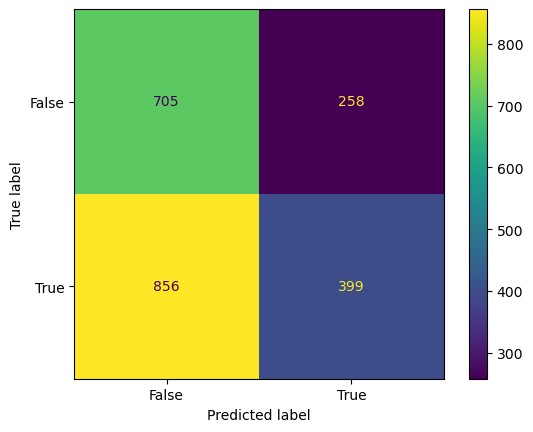

In [37]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(label, predicted_label)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.savefig(foler_loaction + "/plot6.png")
plt.show()


## ML Performance metrics

In the publication paper, the authors have tested the model for accuracy (ACC), balanced accuracy (BAC), Matthews’s correlation coefficient (MCC), F1-score (F1), sensitivity (SEN), specificity (SPE), negative predictive value(NPV), positive predictive value(PPV), area under the receiver operating characteristic curve (AUROC) and area under the precision-recall curve (AUPR). Let's evaluate the model on all these metrics one by one.

### Accuracy(ACC)

Accuracy= (true positives + true negatives) / (true positives + true negatives + false positives + false negatives)

In [38]:
accuracy=(true_positives+true_negatives)/(true_negatives+true_positives+false_negatives+false_positives)
print('Accuracy = ', accuracy)

Accuracy =  0.4977457168620379


### Senstivity(SEN)

Senstivity= true positives  / (true positives + false negatives)

In [39]:
senstivity=(true_positives)/(true_positives+false_negatives)
print('Senstivity = ', senstivity)

Senstivity =  0.3179282868525896


### Specificity(SPE)

Senstivity= true negatives  / (true negatives + false positives)

In [40]:
specificity=(true_negatives)/(true_negatives+false_positives)
print('Specificity = ', specificity)

Specificity =  0.7320872274143302


### Precision / Positive Predictive Value

Positive Predictive Value / Precision= true postives  / (true positives + false positives)

In [41]:
precision=(true_positives)/(true_positives+false_positives)
print('Positive Predictive Value / Precision = ', precision)

Positive Predictive Value / Precision =  0.6073059360730594


### Recall

Recall= true postives  / (true positives + false negatives)

In [42]:
recall=(true_positives)/(true_positives+false_negatives)
print('Recall = ', recall)

Recall =  0.3179282868525896


### Negative Predictive Value

Negative Predictive Value= true negatives  / (true negatives + false negatives)

In [43]:
negative_predictive_value=(true_negatives)/(true_negatives+false_negatives)
print('Negative Predictive Value = ', negative_predictive_value)

Negative Predictive Value =  0.4516335682254965


### Balanced Accuracy

Balanced Accuracy= ( senstivity + specificity )/2

In [44]:
balanced_accuracy=(senstivity+specificity)/2
print('Balanced Accuracy = ', balanced_accuracy)

Balanced Accuracy =  0.5250077571334599


### Matthew's Correlation Coefficient

Matthew's Correlation Coefficient = ( ( TP * TN ) - ( FP * FN ) )/√(( TP + FP) * ( TP + FN) * ( TN + FP ) * ( TN + FN ))

In [45]:
matthew_correlation_coefficient=((true_negatives*true_positives)-(false_negatives*false_positives))/ math.sqrt((true_positives+false_positives)*(true_positives+false_negatives)*(true_negatives+false_positives)*(true_negatives+false_negatives))
print("Matthew's Correlation Coefficient = ", matthew_correlation_coefficient)

Matthew's Correlation Coefficient =  0.05429447134036396


### F1 Score

F1 Score= 2*( Precision * Recall )/ (Precison + Recall)

In [46]:
f1_score=2*(precision*recall)/(precision+recall)
print('F1 Score = ', f1_score)

F1 Score =  0.41736401673640167


## Final Results

| Metric | Value |
|----------|----------|
| Accuracy | 0.497 |
| Senstivity | 0.3179 |
| Specificty | 0.732 |
| Precision / Positive Predictive Value | 0.607 |
| Recall | 0.3179 |
| Negative Predictive Value | 0.4516 |
| Balanced Accuracy | 0.525 |
| Matthew's Correlation Coeffcicient | 0.05429 |
| F1 Score | 0.417 |

### Comments on Results

1. Accuracy and balanced accuracy : these values are nearly 0.5 which means that the classification is almost random and our model has a poor performance.
2. Senstivity: The value is very small ( 0.3179 < 0.5 ). This means of all the positive examples present in the dataset, our classsifier can correctly identify 31% of them showing it's inability to identify a positive molecule.
3. Specificity: The value is 0.732 > 0.5 , which means our classifier is good at correctly classifying the negative exammples which is expected as it is biased towards identifying a molecule as negative.
4. Precision: The value 0.607 > 0.5, this means if our model classifies an example as positive, it has a 60.7% chance to be actually positive. This is expected as our model is biased to give negative results and when it does report a molecule as positive, there is a good chance that it is actually postive.
5. Recall:It's value if 0.3179 < 0.5. This is also expected as recall tells us that out of all the positive examples, what proportion is our model able to identify. We know that our model has a tendency to under-report the positive examples and thus is able to detect only 31.795 of the total positive examples.
6. Negative Predictive value: It is the proportion of examples classified as negative which are actually negative. It's value is 0.4516 < 0.5. This is because our model has a great tendency to report a molecule as negative even though it might be positive. So, if a molecule has been reported as negative, there is just 45.16% chance that it is actually negative.
7. Matthew correlation coefficient: It's value is almost 0 which again shows our model behaves as a random classifier.
8. F1 score: It's low ( just 0.417 ) which indicates poor precision and poor recall.

CONCLUSION : Overall, we can say that our model has an appreciable bias towards reporting examples as negative while under-reporting the positive examples.

In [34]:
# saving all the images in the next section in this location
foler_loaction='/Users/ashitasrivastava/Desktop/projects/ERSILIA/model-validation-example/data/images/comparison'

## Receiver Operating Characteristic Curve

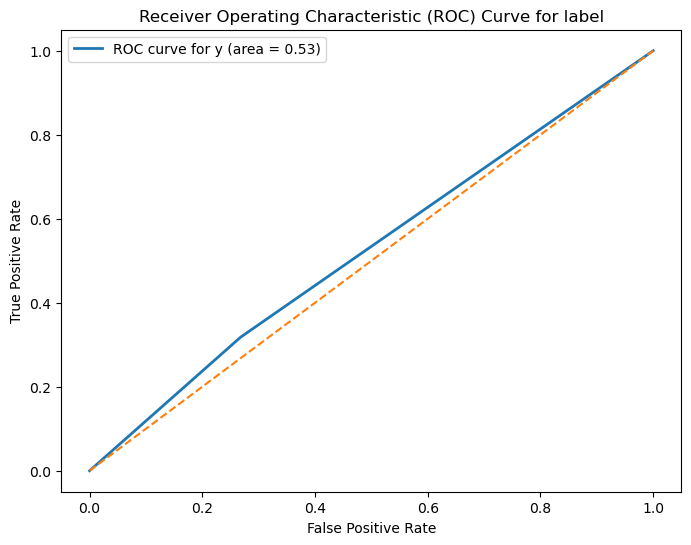

AUROC: 0.5250077571334599
R2 Score: -1.0444510638649973


<Figure size 640x480 with 0 Axes>

In [88]:
from sklearn.metrics import roc_curve,precision_recall_curve,auc, r2_score,roc_auc_score

#ROC curve for label
FPR, TPR, _ = roc_curve(label,predicted_label)   
roc_auc = auc(FPR, TPR)

# Calculate R2 score
r2 = r2_score(label, predicted_label)

#ROC curve for labels
plt.figure(figsize=(8, 6))
plt.plot(FPR, TPR, lw=2, label='ROC curve for y (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for label')
plt.legend()
plt.show()
plt.savefig(foler_loaction + "/plot1.png")

#AUROC and R2 score
print("AUROC:", roc_auc)
print("R2 Score:", r2)

### Inferences

AUROC : It's value is 0.5 which means that the model is more or less just randomly classifying the examples as positive or negative. This happens because out model is very good at identifying the negative examples and at many times overestimating their number. On the other hand, it under-reports the positive examples. This results in an overall random performance.

R2 Score: It's -1 which means that the model performs worse than a naive baseline model and it's better to report an avarage value of the depenedent variable (here the label) than to report predictions from the model.

## Precision Recall Curve

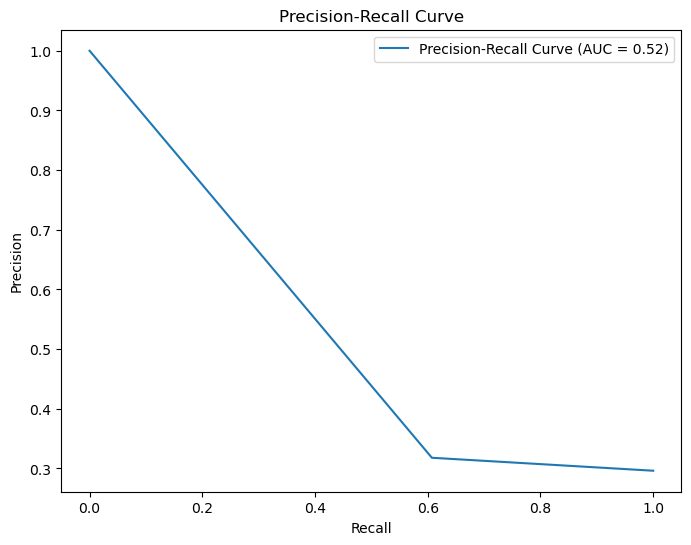

AUPRC 0.5207776164222474


<Figure size 640x480 with 0 Axes>

In [90]:
precision, recall, thresholds = precision_recall_curve(predicted_label,label)
auc_score = auc(recall, precision)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {auc_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()
plt.savefig(foler_loaction + "/plot2.png")
print('AUPRC',auc_score)

### Inferences

The area under th precision recall curve is 0.5 which means that the trade off between precsion and recall is equivalent to a random chanceand the model is ineffective in classifying between the negative and positive classes.

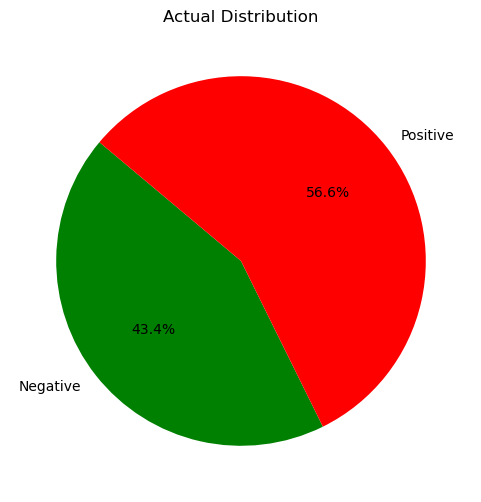

In [91]:
label1 = ['Negative' if x == 0 else 'Positive' for x in label]
label_values, label_counts = np.unique(label1, return_counts=True)
plt.figure(figsize=(6, 6))
colors=['green','red']
plt.pie(label_counts, labels=label_values, autopct='%1.1f%%', startangle=140,colors=colors)
plt.title('Actual Distribution')
plt.savefig(foler_loaction + "/plot3.png")
plt.show()

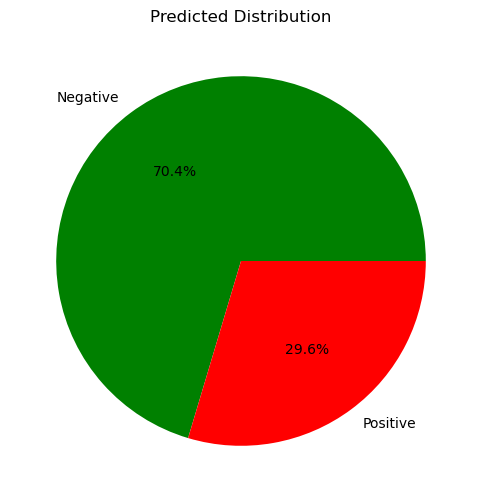

In [92]:
label2 = ['Negative' if x == 0 else 'Positive' for x in predicted_label]

label_values, label_counts = np.unique(label2, return_counts=True)
plt.figure(figsize=(6, 6))
colors=['green','red']
plt.pie(label_counts, labels=label_values, autopct='%1.1f%%', startangle=0,colors=colors)
plt.title('Predicted Distribution')
plt.savefig(foler_loaction + "/plot4.png")
plt.show()

## Comparison between Actual Districution and predicted distribution

### Bar Graph 📊

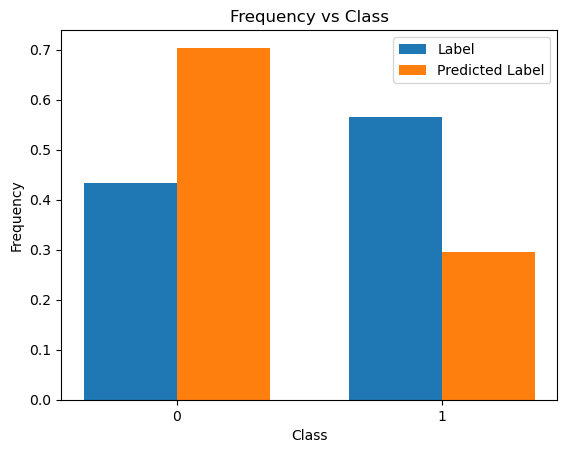

In [93]:
# Count the frequency of values in the lists
label_values, label_counts = np.unique(label, return_counts=True)
label_predicted_values, label_predicted_counts = np.unique(predicted_label, return_counts=True)

# Plotting
width = 0.35  # Width of the bars
x = np.arange(len(label_values))  # The label locations

label_counts_scaled = label_counts / 2218 #(normalise)
label_predicted_counts_scaled = label_predicted_counts / 2218 #(normalise)
fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, label_counts_scaled, width, label='Label')
bars2 = ax.bar(x + width/2, label_predicted_counts_scaled, width, label='Predicted Label')
ax.set_ylabel('Frequency')
ax.set_xlabel('Class')
ax.set_title('Frequency vs Class')
ax.set_xticks(x)
plt.legend()
plt.savefig(foler_loaction + "/plot5.png")
plt.show()

### Inferences

We can clearly see the the actual dataset contains more positive examples than negative examples but our model reports more negative examples than positive examples. Claerly, its biased towards giving negative results.

### Pie chart 🟡

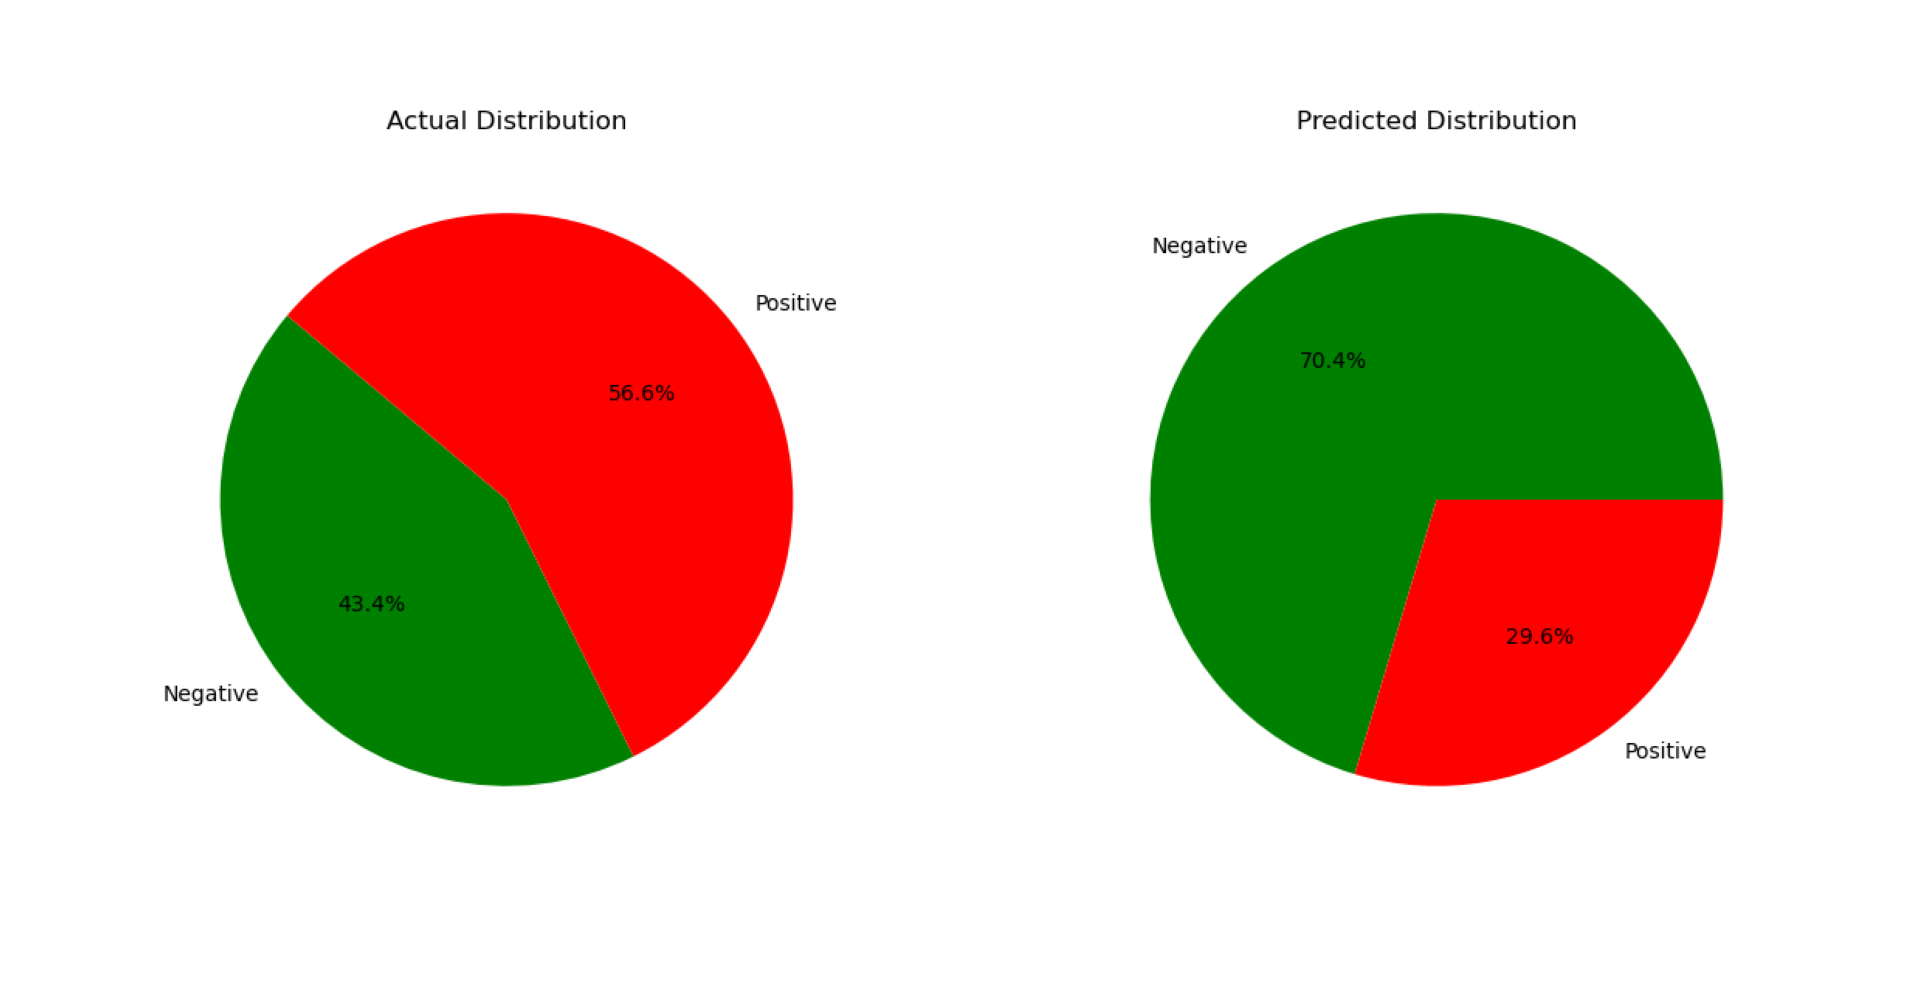

In [94]:
### Comparing the pie charts

image = plt.imread('/Users/ashitasrivastava/Desktop/projects/ERSILIA/model-validation-example/data/images/comparison/pie_charts_actual_predicted.png')
plt.figure(figsize=(8, 8),dpi=300)
plt.imshow(image)
plt.axis('off')
plt.show()

### Inferences

The actual distribution has 56.6% positive examples and 43.4% negative examples. However, the model predicts 70.4% negative examples and 29.6% positive examples which again shows the bias of model towards giving negative results.

## Final Note ✔️

We reproduced the model in the second week. The dataset had more negative examples than positive examples. Our model gave decent results but gave an error 0f 14.7% in predciting hERG blockers. However, in the dataset we used in evaluation of model , the number of positive examplesc(1255) is larger than the number of negative examples(963).Since our model is biased towards reporting negative values, it performed poorly and almost acted like a random classifier. Thus , we need to work on the ability of the model to predict hERG blockers and especially the strong hERG blockers.